### BZAN 6355 Adv Prog Big-Data Anlytc
***

## Important!
1. To properly show the "ER Diagram" in a Markdown cell below, be sure to keep the image file `"class_final_project-ER_diagram.png"` in the same directory as this Jupyter Notebook file, and always move/copy the two files together.

## Project Domain and Dataset
***
### Predicting the Sales Price of Real Estate Properties
The entire Train data consist of 4 data files (.csv format), that is, "Property_Survey_1", "Property_Survey_2", "House_Features", and "Quality_Assessment". After _reading_ each data file, eventually one might want to merge them into a single DataFrame; before merging, however, one need to understand the underlying _associations_ of the data contained in each of the data files. The following graph shows the associations:
<img src="class_final_project-ER_diagram.png" style="width:854px; height:807px">

Clearly, `"PID"` is the primary key of each table in this ER diagram, and although not drawn in the diagram, one should be able to infer the cardinality.<br><br>`"SalePrice"` is the target variable.<br><br>It should be noted that there are two (2) Property Survey data files each with the same list of columns, and one should be able to figure out how to deal with the property survey data files and append the data together to make a single (1) Property Survey dataset.<br><br>Before actually merging them into a single `DataFrame`, one need to first understand each individual `DataFrame`.

## Additional Technical Notes
***
To predict the sales price of 100 real estate properties before they are actually sold. To build the best model with the highest predictive power, train many models and select the best one which will be deployed into making the predictions.

There are several ways one can try to boost the generalizability of the model without having to build super complex algorithms.

**One approach** is to spend a good amount of time understanding the data in terms of the **informative attributes**. What are the correlations between the target variable and the input variables? What input variables might be redundant?

An attribute (i.e., feature, variable) isn't necessarily informative in its original scale and shape. One can consider transforming it to make it more "accessible" for the algorithms to exploit. Besides the necessary techniques that one has to use in order to include the variables of certain types, e.g.,
- categorizing, recoding, and/or re-weighting nominal variables
- standardizing interval variables for algorithms such as kNN

one may also logarithm-transform certain interval input variables, and maybe even the target variable, if the true relationship between the target and the input variables are better captured after log-transformation. This may be true if both the target and the input variables are interval and have similarly skewed distributions with outliers that similarly lie at the extreme end(s) of the corresponding distribution. In this case, log-transforming both the target and the input will help better deal with the outliers and decrease the _mean absolute percentage error_.

**Another approach** is to fine-tune the model parameters. It depends on the specific algorithms:
- Linear Regression:
    - One may add polinomial terms to try to capture non-linear patterns (i.e., squared or exponential of a variable) and interaction terms (i.e., product of two or more variables)
    - One may experiment with the _feature selection_ tools (introduced and demonstrated in **Module 9**) to select varous sized bundle of informative attributes
- k-Nearest-Neighbor:
    - In this case, one may assign custom weights instead of using either uniform or distance-adjusted weights as defined by the package within `sklearn`

Though increasing model complexity can help improve accuracy, one needs to avoid too much of overfitting. The art of balancing the bias-variance tradeoff is a topic of _regularization_. Regularization is beyond the scope of this course; however, I encourage to self-learn the essence this concept and explore the regularization tools provided in `sklearn` or even beyond `sklearn` package. <u>_That said, this is not required, and is only recommended after all other necessary steps have been tried and incorporated._</u> Good luck!

<div class="alert alert-block alert-info"><b>For full project description and requirements, see the project description document "Class_Project_Description.pdf"</b></div>

***
# Preparation

## Step 0. Import Necessary Packages, Define Utilities
Import packages and, if needed, define any custom functions that may help enhance the efficiency of the project flow as well as readability of the project codes

In [1083]:
#Import Packages 

import pandas as pd
import numpy as np
from numpy import nan as NA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [1084]:
import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_score


In [1085]:
%matplotlib inline

In [1086]:
import statsmodels.api as sm
from sklearn import preprocessing
import sklearn.linear_model as lm
import sklearn.neighbors as knn

In [1087]:
from sklearn.model_selection import cross_val_score
# for imputing missing values
from sklearn.impute import SimpleImputer
# for transformation pipelines
from sklearn.pipeline import Pipeline, make_pipeline
# for custom column transformer
from sklearn.compose import ColumnTransformer, make_column_transformer

***
# Data Management

## Step 1.1: Import Train Datasets, Understand Basic Info About Properties in each DataFrame
#### Note, the Train datasets refer to all of the raw data that will be used for training and validating models! The Train data can be used to conduct x-valid analysis
**The basic info one should check of each individual DataFrame include, but not limited to, the following:**
- shape, columns and data types
- interval variables: summary statistics
- nominal/binary variables: distributions of unique levels
- both interval and nominal variables: skewness of distributions and possible outliers
- missing values

**Should something be done to the two "Property Survey" data files first before conducting surface-level explorations of the variables in these data?**

>Data File _Quality Assessment_ : Don't forget to check if there is any duplicate properties (in terms of the `"PID"` column values) between the two Property Survey datasets before doing anything about them; if there is, what's the best way to deal with them?

**Should one conduct deep EDAs (see below step) _before_ or _after_ merging the separate DataFames into a single DataFrame?**

After merging them into a single DataFrame, it will be wide! This means there will be many columns in this **big** DataFrame. Will one be able to manage the EDAs well by working with this big DataFrame, or will it be better off to deal with each DataFrame first before merging them in order to get correlation matrix, etc.?

In [1088]:
#import datasets
PropSurvey1 = pd.read_csv('Property_Survey_1.csv')
PropSurvey2 = pd.read_csv('Property_Survey_2.csv')
HouseFeatures = pd.read_csv('House_Feature.csv')
Q_Assesment = pd.read_csv('Quality_Assessment.csv')

## Shape, Columns, and Data Types

<div class="alert alert-block alert-danger"><b>Alert!</b> Carefully compare the Score Data with the training data. Notice any difference in the columns</div>

In [1089]:
#Shape of four datasets
print('PropSurvey1 has dimensions of {0}'.format(PropSurvey1.shape))
print('PropSurvey2 has dimensions of {0}'.format(PropSurvey2.shape))
print('HouseFeatures has dimensions of {0}'.format(HouseFeatures.shape))
print('Q_Assesment has dimensions of {0}'.format(Q_Assesment.shape))

PropSurvey1 has dimensions of (600, 4)
PropSurvey2 has dimensions of (1770, 4)
HouseFeatures has dimensions of (2370, 23)
Q_Assesment has dimensions of (2370, 3)


In [1090]:
print('PropertySurvey1 contains the following column headers with corresponding data types :')
PropSurvey1.dtypes

PropertySurvey1 contains the following column headers with corresponding data types :


PID         int64
LotArea     int64
LotShape    int64
BldgTp      int64
dtype: object

In [1091]:
print('PropertySurvey2 contains the following column headers with corresponding data types :')
PropSurvey2.dtypes

PropertySurvey2 contains the following column headers with corresponding data types :


PID         int64
LotArea     int64
LotShape    int64
BldgTp      int64
dtype: object

In [1092]:
print('HouseFeatures contains the following column headers with corresponding data types :')
HouseFeatures.dtypes

HouseFeatures contains the following column headers with corresponding data types :


PID               int64
YearBuilt         int64
YearRemodel       int64
VeneerExterior    int64
BsmtFinTp         int64
BsmtFinSqft       int64
BsmtUnfinSqft     int64
HeatingQC         int64
FstFlrSqft        int64
SecFlrSqft        int64
AbvGrndLiving     int64
FullBathBsmt      int64
HalfBathHouse     int64
FullBathHouse     int64
BdrmAbvGrnd       int64
RmAbvGrnd         int64
Fireplaces        int64
GarageTp          int64
GarageCars        int64
GarageArea        int64
WdDckSqft         int64
OpenPrchSqft      int64
SalePrice         int64
dtype: object

In [1093]:
print('Q_Assesment contains the following column headers with corresponding data types :')
Q_Assesment.dtypes

Q_Assesment contains the following column headers with corresponding data types :


PID                 int64
OverallQuality      int64
OverallCondition    int64
dtype: object

In [1094]:
def age_calc(x):
    return 2021 - x

In [1095]:

HouseFeatures["YearBuilt"] = HouseFeatures["YearBuilt"].apply(age_calc)

In [1096]:
HouseFeatures.head()

,PID,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,FstFlrSqft,SecFlrSqft,...,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice
0,526301100,61,1960,112,1,639,441,0,1656,0,...,1,3,7,2,3,2,528,210,62,215000
1,526350040,60,1961,0,1,468,270,1,896,0,...,1,2,5,0,3,1,730,140,0,105000
2,526351010,63,1958,108,1,923,406,1,1329,0,...,1,3,6,0,3,1,312,393,36,172000
3,526353030,53,1968,0,1,1065,1045,3,2110,0,...,2,3,8,2,3,2,522,0,0,244000
4,527105010,24,1998,0,1,791,137,2,928,701,...,2,3,6,1,3,2,482,212,34,189900


In [1097]:
HouseFeatures.rename(columns={'YearBuilt': 'Age'}, inplace=True)

In [1098]:
HouseFeatures.head()

,PID,Age,YearRemodel,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,FstFlrSqft,SecFlrSqft,...,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice
0,526301100,61,1960,112,1,639,441,0,1656,0,...,1,3,7,2,3,2,528,210,62,215000
1,526350040,60,1961,0,1,468,270,1,896,0,...,1,2,5,0,3,1,730,140,0,105000
2,526351010,63,1958,108,1,923,406,1,1329,0,...,1,3,6,0,3,1,312,393,36,172000
3,526353030,53,1968,0,1,1065,1045,3,2110,0,...,2,3,8,2,3,2,522,0,0,244000
4,527105010,24,1998,0,1,791,137,2,928,701,...,2,3,6,1,3,2,482,212,34,189900


In [1099]:

HouseFeatures["YearRemodel"] = HouseFeatures["YearRemodel"].apply(age_calc)

In [1100]:
HouseFeatures.rename(columns={'YearRemodel': 'RemodelAge'}, inplace=True)

In [1101]:
HouseFeatures.head()

,PID,Age,RemodelAge,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,FstFlrSqft,SecFlrSqft,...,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice
0,526301100,61,61,112,1,639,441,0,1656,0,...,1,3,7,2,3,2,528,210,62,215000
1,526350040,60,60,0,1,468,270,1,896,0,...,1,2,5,0,3,1,730,140,0,105000
2,526351010,63,63,108,1,923,406,1,1329,0,...,1,3,6,0,3,1,312,393,36,172000
3,526353030,53,53,0,1,1065,1045,3,2110,0,...,2,3,8,2,3,2,522,0,0,244000
4,527105010,24,23,0,1,791,137,2,928,701,...,2,3,6,1,3,2,482,212,34,189900


In [1102]:

HouseFeatures["AgeRemodelYears"] = HouseFeatures["Age"] + HouseFeatures["RemodelAge"]

In [1103]:
HouseFeatures.drop('Age',  inplace=True, axis=1)
HouseFeatures.drop('RemodelAge',  inplace=True, axis=1)

In [1104]:
HouseFeaturescols = HouseFeatures.columns.tolist()
HouseFeaturescols

['PID',
 'VeneerExterior',
 'BsmtFinTp',
 'BsmtFinSqft',
 'BsmtUnfinSqft',
 'HeatingQC',
 'FstFlrSqft',
 'SecFlrSqft',
 'AbvGrndLiving',
 'FullBathBsmt',
 'HalfBathHouse',
 'FullBathHouse',
 'BdrmAbvGrnd',
 'RmAbvGrnd',
 'Fireplaces',
 'GarageTp',
 'GarageCars',
 'GarageArea',
 'WdDckSqft',
 'OpenPrchSqft',
 'SalePrice',
 'AgeRemodelYears']

In [1105]:
cols = HouseFeaturescols[0:1]+HouseFeaturescols[-1:] + HouseFeaturescols[1:-1]

In [1106]:
cols

['PID',
 'AgeRemodelYears',
 'VeneerExterior',
 'BsmtFinTp',
 'BsmtFinSqft',
 'BsmtUnfinSqft',
 'HeatingQC',
 'FstFlrSqft',
 'SecFlrSqft',
 'AbvGrndLiving',
 'FullBathBsmt',
 'HalfBathHouse',
 'FullBathHouse',
 'BdrmAbvGrnd',
 'RmAbvGrnd',
 'Fireplaces',
 'GarageTp',
 'GarageCars',
 'GarageArea',
 'WdDckSqft',
 'OpenPrchSqft',
 'SalePrice']

In [1107]:
HouseFeatures = HouseFeatures[cols]

In [1108]:
HouseFeatures.head()

,PID,AgeRemodelYears,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,FstFlrSqft,SecFlrSqft,AbvGrndLiving,...,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice
0,526301100,122,112,1,639,441,0,1656,0,1656,...,1,3,7,2,3,2,528,210,62,215000
1,526350040,120,0,1,468,270,1,896,0,896,...,1,2,5,0,3,1,730,140,0,105000
2,526351010,126,108,1,923,406,1,1329,0,1329,...,1,3,6,0,3,1,312,393,36,172000
3,526353030,106,0,1,1065,1045,3,2110,0,2110,...,2,3,8,2,3,2,522,0,0,244000
4,527105010,47,0,1,791,137,2,928,701,1629,...,2,3,6,1,3,2,482,212,34,189900


In [1109]:
print('Q_Assesment contains the following column headers with corresponding data types :')
Q_Assesment.dtypes

Q_Assesment contains the following column headers with corresponding data types :


PID                 int64
OverallQuality      int64
OverallCondition    int64
dtype: object

In [1110]:
print('There are no interval variables for Q_Assesment')

There are no interval variables for Q_Assesment


## Interval Variables : Summary Statistics

In [1111]:
print('Summary statistics for interval variables of PropSurvey1 :')
PropSurvey1[['LotArea']].describe()

Summary statistics for interval variables of PropSurvey1 :


,LotArea
count,600.000000
mean,9403.418333
std,4636.681113
min,1476.000000
25%,7205.250000
50%,9343.500000
75%,10995.500000
max,57200.000000


In [1112]:
print('Summary statistics for interval variables of PropSurvey2 :')
PropSurvey2[['LotArea']].describe()

Summary statistics for interval variables of PropSurvey2 :


,LotArea
count,1770.000000
mean,9801.694915
std,6587.298945
min,1300.000000
25%,7200.000000
50%,9305.500000
75%,11268.750000
max,159000.000000


In [1113]:
print('Summary statistics for interval variables of HouseFeatures :')
HF_IntVars = ['AgeRemodelYears','VeneerExterior','BsmtFinSqft','BsmtUnfinSqft','FstFlrSqft','SecFlrSqft','FullBathHouse','BdrmAbvGrnd','RmAbvGrnd','Fireplaces','GarageCars','GarageArea','WdDckSqft','OpenPrchSqft','SalePrice']
HouseFeatures[HF_IntVars].describe()

Summary statistics for interval variables of HouseFeatures :


,AgeRemodelYears,VeneerExterior,BsmtFinSqft,BsmtUnfinSqft,FstFlrSqft,SecFlrSqft,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice
count,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,87.342194,88.143882,429.805907,557.101688,1116.442616,325.198734,1.508017,2.816456,6.258650,0.589451,1.718987,457.978903,91.650633,46.002532,173730.772574
std,45.537647,158.718586,408.779757,410.685375,344.282409,406.198426,0.501727,0.742817,1.392625,0.630429,0.708998,197.608559,120.616635,64.245617,64080.843305
min,22.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12789.000000
25%,42.250000,0.000000,0.000000,239.250000,864.000000,0.000000,1.000000,2.000000,5.000000,0.000000,1.000000,312.000000,0.000000,0.000000,129900.000000
50%,88.000000,0.000000,378.000000,470.000000,1056.000000,0.000000,2.000000,3.000000,6.000000,1.000000,2.000000,463.000000,0.000000,25.000000,159000.000000
75%,122.000000,144.000000,715.500000,792.000000,1331.500000,688.750000,2.000000,3.000000,7.000000,1.000000,2.000000,572.000000,168.000000,68.000000,207000.000000
max,212.000000,1600.000000,2085.000000,2140.000000,2898.000000,1721.000000,2.000000,6.000000,12.000000,4.000000,5.000000,1488.000000,736.000000,547.000000,475000.000000


## Nominal/Binary Variables: Distributions of Unique Levels

In [1114]:
#Distribution of nomianl variables of PropSurvey1
print('Distriution of Lot Shape in PropSurvey1 :')
PropSurvey1['LotShape'].value_counts()

Distriution of Lot Shape in PropSurvey1 :


1    398
0    202
Name: LotShape, dtype: int64

In [1115]:
#Distribution of nomianl variables of PropSurvey1
print('Distriution of Lot Shape in PropSurvey2 :')
PropSurvey2['LotShape'].value_counts()

Distriution of Lot Shape in PropSurvey2 :


1    1127
0     643
Name: LotShape, dtype: int64

In [1116]:
#Distribution of nomianl variables of HouseFeatures
print('Distriution of Basement Finish Type in HouseFeatures :')

HouseFeatures['BsmtFinTp'].value_counts()


Distriution of Basement Finish Type in HouseFeatures :


1    1670
0     700
Name: BsmtFinTp, dtype: int64

In [1117]:
#Distribution of nomianl variables of HouseFeatures
print('Distriution of Heating Quality Condition in HouseFeatures :')

HouseFeatures['HeatingQC'].value_counts()

Distriution of Heating Quality Condition in HouseFeatures :


3    1200
1     704
2     400
0      66
Name: HeatingQC, dtype: int64

In [1118]:
#Distribution of nomianl variables of HouseFeatures
print('Distriution of Garage Type in HouseFeatures :')

HouseFeatures['GarageTp'].value_counts() 

Distriution of Garage Type in HouseFeatures :


3    1444
1     682
2     139
0     105
Name: GarageTp, dtype: int64

In [1119]:
#Distribution of nomianl variables of QAssesment
print('Distriution of Overall Quality in Q_Assesment :')

Q_Assesment['OverallQuality'].value_counts()

Distriution of Overall Quality in Q_Assesment :


5     686
6     644
7     506
8     302
4     163
9      38
3      24
2       6
10      1
Name: OverallQuality, dtype: int64

In [1120]:
#Distribution of nomianl variables of QAssesment
print('Distriution of Overall Condition in Q_Assesment :')

Q_Assesment['OverallCondition'].value_counts()

Distriution of Overall Condition in Q_Assesment :


5    1299
6     459
7     343
8     129
4      68
3      32
9      31
2       6
1       3
Name: OverallCondition, dtype: int64

## Append and Merge All DataFrames into One

In [1121]:
#Check missing values in all datasets
print('PropSurvey1 has', PropSurvey1.isnull().sum().sum(), 'missing values.')
print('PropSurvey2 has', PropSurvey2.isnull().sum().sum(), 'missing values.')
print('HouseFeatures has', HouseFeatures.isnull().sum().sum(), 'missing values.')
print('Q_Assesment has', Q_Assesment.isnull().sum().sum(), 'missing values.')


PropSurvey1 has 0 missing values.
PropSurvey2 has 0 missing values.
HouseFeatures has 0 missing values.
Q_Assesment has 0 missing values.


In [1122]:
#Append PropSurvey1 and PropSurvey2 into single PropSurvey DF

PropSurv = PropSurvey1.append([PropSurvey2])
PropSurv.head(4)


,PID,LotArea,LotShape,BldgTp
0,526301100,31770,0,1
1,526350040,11622,1,1
2,526351010,14267,0,1
3,526353030,11160,1,1


In [1123]:
#Check for null in new PropSurv
print('PropSurv has', PropSurv.isnull().sum().sum(), 'missing values.')

PropSurv has 0 missing values.


In [1124]:
#Merge PropSurv with HouseFeatures
PropSurv_HF = pd.merge(left=PropSurv, right=HouseFeatures, on='PID', how='inner', validate='1:1')
PropSurv_HF.head(4)

,PID,LotArea,LotShape,BldgTp,AgeRemodelYears,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,...,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice
0,526301100,31770,0,1,122,112,1,639,441,0,...,1,3,7,2,3,2,528,210,62,215000
1,526350040,11622,1,1,120,0,1,468,270,1,...,1,2,5,0,3,1,730,140,0,105000
2,526351010,14267,0,1,126,108,1,923,406,1,...,1,3,6,0,3,1,312,393,36,172000
3,526353030,11160,1,1,106,0,1,1065,1045,3,...,2,3,8,2,3,2,522,0,0,244000


In [1125]:
print('PropSurv_HF has', PropSurv_HF.isnull().sum().sum(), 'missing values.')

PropSurv_HF has 0 missing values.


In [1126]:
# Merge PropSurv_HF with Q_Assesment
# This is the final merged dataset
TrainingSet = pd.merge(left=PropSurv_HF, right=Q_Assesment, on='PID', how='inner', validate='1:1')
TrainingSet.head(4)

,PID,LotArea,LotShape,BldgTp,AgeRemodelYears,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,...,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice,OverallQuality,OverallCondition
0,526301100,31770,0,1,122,112,1,639,441,0,...,7,2,3,2,528,210,62,215000,6,5
1,526350040,11622,1,1,120,0,1,468,270,1,...,5,0,3,1,730,140,0,105000,5,6
2,526351010,14267,0,1,126,108,1,923,406,1,...,6,0,3,1,312,393,36,172000,6,6
3,526353030,11160,1,1,106,0,1,1065,1045,3,...,8,2,3,2,522,0,0,244000,7,5


In [1127]:
print('TrainingSet has', TrainingSet.isnull().sum().sum(), 'missing values.')

TrainingSet has 0 missing values.


## Both Interval and Nominal Variables: Skewness of Distributions and Possible Outliers

Text(0, 0.5, 'Count')

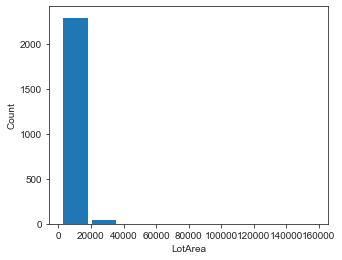

In [1128]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['LotArea'].plot.hist(bins=9, rwidth=0.9)

pltYearBuilt.set_xlabel('LotArea')
pltYearBuilt.set_ylabel('Count')

Text(0.5, 1.0, 'AgeRemodelYears')

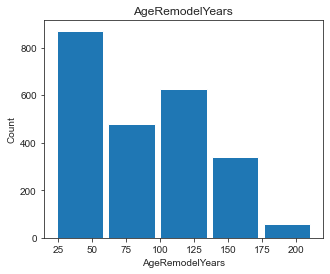

In [1129]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['AgeRemodelYears'].plot.hist(bins=5, rwidth=0.9)

pltYearBuilt.set_xlabel('AgeRemodelYears')
pltYearBuilt.set_ylabel('Count')
pltYearBuilt.set_title('AgeRemodelYears')

Text(0.5, 1.0, 'VeneerExterior Area')

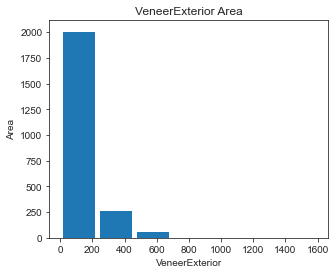

In [1130]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['VeneerExterior'].plot.hist(bins=7, rwidth=0.9)

pltYearBuilt.set_xlabel('VeneerExterior')
pltYearBuilt.set_ylabel('Area')
pltYearBuilt.set_title('VeneerExterior Area')

Text(0.5, 1.0, 'BsmtFinSqft Area')

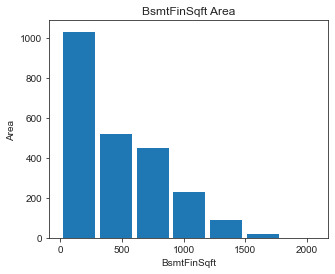

In [1131]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['BsmtFinSqft'].plot.hist(bins=7, rwidth=0.9)

pltYearBuilt.set_xlabel('BsmtFinSqft')
pltYearBuilt.set_ylabel('Area')
pltYearBuilt.set_title('BsmtFinSqft Area')

Text(0.5, 1.0, 'BsmtUnfinSqft Area')

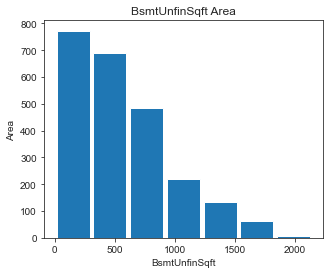

In [1132]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['BsmtUnfinSqft'].plot.hist(bins=7, rwidth=0.9)

pltYearBuilt.set_xlabel('BsmtUnfinSqft')
pltYearBuilt.set_ylabel('Area')
pltYearBuilt.set_title('BsmtUnfinSqft Area')

Text(0.5, 1.0, 'FstFlrSqft Area')

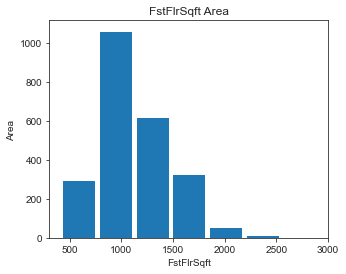

In [1133]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['FstFlrSqft'].plot.hist(bins=7, rwidth=0.9)

pltYearBuilt.set_xlabel('FstFlrSqft')
pltYearBuilt.set_ylabel('Area')
pltYearBuilt.set_title('FstFlrSqft Area')

Text(0.5, 1.0, 'SecFlrSqft Area')

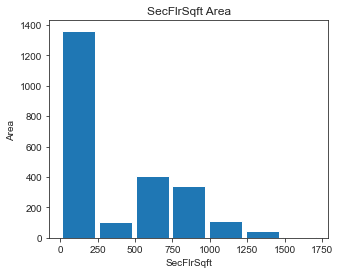

In [1134]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['SecFlrSqft'].plot.hist(bins=7, rwidth=0.9)

pltYearBuilt.set_xlabel('SecFlrSqft')
pltYearBuilt.set_ylabel('Area')
pltYearBuilt.set_title('SecFlrSqft Area')

Text(0, 0.5, 'Count')

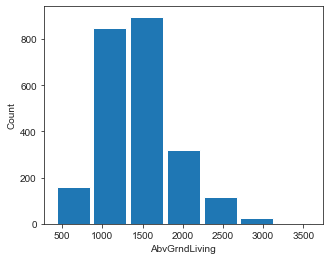

In [1135]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['AbvGrndLiving'].plot.hist(bins=7, rwidth=0.9)

pltYearBuilt.set_xlabel('AbvGrndLiving')
pltYearBuilt.set_ylabel('Count')

Text(0, 0.5, 'House Count')

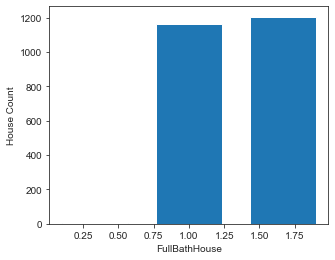

In [1136]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['FullBathHouse'].plot.hist(bins=3, rwidth=0.7)

pltYearBuilt.set_xlabel('FullBathHouse')
pltYearBuilt.set_ylabel('House Count')

Text(0, 0.5, 'Count')

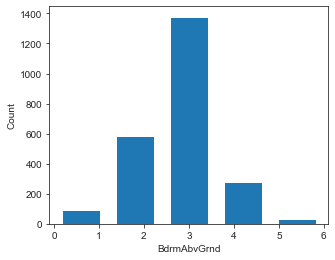

In [1137]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['BdrmAbvGrnd'].plot.hist(bins=5, rwidth=0.7)

pltYearBuilt.set_xlabel('BdrmAbvGrnd')
pltYearBuilt.set_ylabel('Count')

Text(0, 0.5, 'Count')

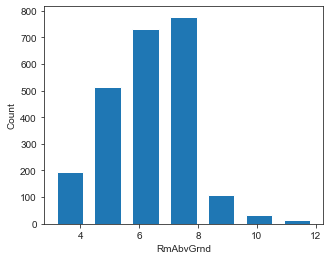

In [1138]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['RmAbvGrnd'].plot.hist(bins=7, rwidth=0.7)

pltYearBuilt.set_xlabel('RmAbvGrnd')
pltYearBuilt.set_ylabel('Count')

Text(0, 0.5, 'House Count')

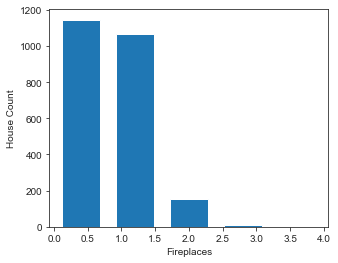

In [1139]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['Fireplaces'].plot.hist(bins=5, rwidth=0.7)

pltYearBuilt.set_xlabel('Fireplaces')
pltYearBuilt.set_ylabel('House Count')

Text(0, 0.5, 'House Count')

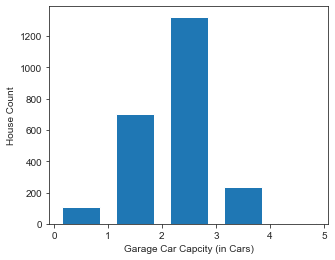

In [1140]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['GarageCars'].plot.hist(bins=5, rwidth=0.7)

pltYearBuilt.set_xlabel('Garage Car Capcity (in Cars)')
pltYearBuilt.set_ylabel('House Count')

Text(0, 0.5, 'Area')

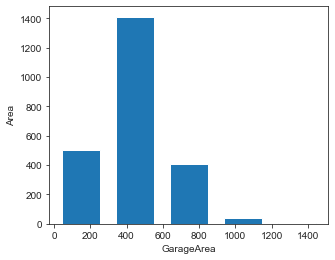

In [1141]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['GarageArea'].plot.hist(bins=5, rwidth=0.7)

pltYearBuilt.set_xlabel('GarageArea')
pltYearBuilt.set_ylabel('Area')

Text(0, 0.5, 'Area')

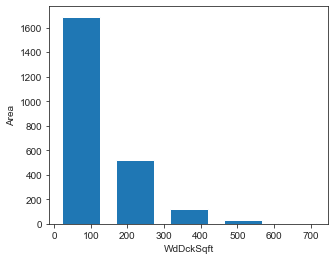

In [1142]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['WdDckSqft'].plot.hist(bins=5, rwidth=0.7)

pltYearBuilt.set_xlabel('WdDckSqft')
pltYearBuilt.set_ylabel('Area')

Text(0, 0.5, 'Area')

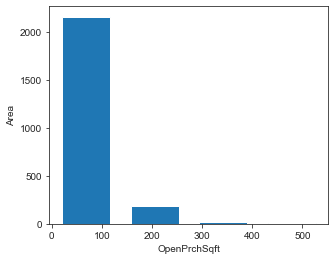

In [1143]:
fignew = plt.figure(figsize=(5, 4))
# "rwidth=" specifies the percent of the x range ocupied by each bin to be reserved for some white gap between bins
pltYearBuilt = TrainingSet['OpenPrchSqft'].plot.hist(bins=4, rwidth=0.7)

pltYearBuilt.set_xlabel('OpenPrchSqft')
pltYearBuilt.set_ylabel('Area')

In [1144]:
#  Skewness shown in LotArea, VeneerExterior, and OpenPrchSqft

## Step 1.2: Import & Understand Score Dataset

In [1145]:
Score = pd.read_csv('Score_Data-No_Sale_Price.csv')

In [1146]:
Score.head()

,PID,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,...,HalfBathHouse,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft
0,528445060,8987,1,1,8,5,2005,2006,226.0,0,...,0,2,2.0,6.0,1,3,3,880,144,0
1,528456160,9215,1,1,7,5,2009,2010,0.0,0,...,0,2,2.0,4.0,0,3,2,676,0,136
2,528458070,8640,1,1,7,5,2009,2009,0.0,1,...,1,2,3.0,7.0,0,3,2,614,169,45
3,906380190,6762,1,1,7,5,2006,2006,24.0,1,...,0,2,2.0,6.0,0,3,2,632,105,61
4,906385010,10402,0,1,7,5,2009,2009,0.0,0,...,0,2,3.0,6.0,0,3,3,740,0,36


In [1147]:
TrainingSet.head()

,PID,LotArea,LotShape,BldgTp,AgeRemodelYears,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,...,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice,OverallQuality,OverallCondition
0,526301100,31770,0,1,122,112,1,639,441,0,...,7,2,3,2,528,210,62,215000,6,5
1,526350040,11622,1,1,120,0,1,468,270,1,...,5,0,3,1,730,140,0,105000,5,6
2,526351010,14267,0,1,126,108,1,923,406,1,...,6,0,3,1,312,393,36,172000,6,6
3,526353030,11160,1,1,106,0,1,1065,1045,3,...,8,2,3,2,522,0,0,244000,7,5
4,527105010,13830,0,1,47,0,1,791,137,2,...,6,1,3,2,482,212,34,189900,5,5


After careful observation, we discovered that there is no Sales Price in the Score dataset.

***
# Exploratory Data Analyses & Finish Data Preprocessing

## Step 2: Deep EDAs, Confirm Assumptions & Generate Leads
Build codes, and/or identify any reason for building custom functions and using them (note: custom functions should be included in the `"Step 0. Import Necessary Packages, Define Utilities"` section), in order to gather some intelligence about the different input variables and their potential informative-ness in regards to the target variable

In [1148]:

import seaborn as sns
sns.set_style('ticks')

In [1149]:
TrainingSet.corr()

,PID,LotArea,LotShape,BldgTp,AgeRemodelYears,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,...,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,SalePrice,OverallQuality,OverallCondition
PID,1.000000,0.033321,0.117828,0.157367,0.280954,-0.209688,-0.086958,-0.112254,-0.047409,-0.068412,...,-0.068212,-0.089072,-0.284161,-0.226571,-0.196249,-0.030366,-0.072043,-0.220939,-0.235921,0.137142
LotArea,0.033321,1.000000,-0.245026,0.354803,-0.025606,0.108173,0.035284,0.141155,0.052453,0.002976,...,0.217184,0.261200,0.194103,0.176603,0.203278,0.117744,0.090270,0.290162,0.080854,-0.033855
LotShape,0.117828,-0.245026,1.000000,-0.063758,0.277061,-0.091866,-0.078355,-0.151263,-0.004748,-0.120582,...,-0.135676,-0.187162,-0.246136,-0.250359,-0.219441,-0.167002,-0.096851,-0.322661,-0.256937,0.099448
BldgTp,0.157367,0.354803,-0.063758,1.000000,0.243153,-0.070431,-0.081584,-0.035602,0.062998,-0.072598,...,0.275416,0.035758,-0.034654,-0.023170,0.046293,0.007968,-0.002307,0.035231,-0.142992,0.143696
AgeRemodelYears,0.280954,-0.025606,0.277061,0.243153,1.000000,-0.246364,-0.060852,-0.197930,-0.154819,-0.522912,...,-0.171197,-0.135878,-0.481546,-0.547475,-0.477487,-0.240186,-0.247071,-0.626278,-0.620282,0.260073
VeneerExterior,-0.209688,0.108173,-0.091866,-0.070431,-0.246364,1.000000,0.114318,0.220944,0.044521,0.133432,...,0.214808,0.229848,0.228365,0.315848,0.307945,0.120585,0.102535,0.415283,0.333396,-0.135116
BsmtFinTp,-0.086958,0.035284,-0.078355,-0.081584,-0.060852,0.114318,1.000000,0.680872,-0.596296,-0.086697,...,-0.134812,0.119763,0.204253,0.036914,0.077142,0.096963,-0.018852,0.116483,-0.012968,0.028086
BsmtFinSqft,-0.112254,0.141155,-0.151263,-0.035602,-0.197930,0.220944,0.680872,1.000000,-0.581040,0.027391,...,-0.021538,0.253205,0.299605,0.213129,0.256428,0.195898,0.071901,0.384289,0.170686,-0.046918
BsmtUnfinSqft,-0.047409,0.052453,-0.004748,0.062998,-0.154819,0.044521,-0.596296,-0.581040,1.000000,0.195086,...,0.228299,-0.002260,0.050486,0.181349,0.152591,-0.073316,0.107748,0.158441,0.265052,-0.152395
HeatingQC,-0.068412,0.002976,-0.120582,-0.072598,-0.522912,0.133432,-0.086697,0.027391,0.195086,1.000000,...,0.206045,0.083280,0.177562,0.328696,0.285335,0.095389,0.189586,0.438989,0.424262,-0.053227


<AxesSubplot:>

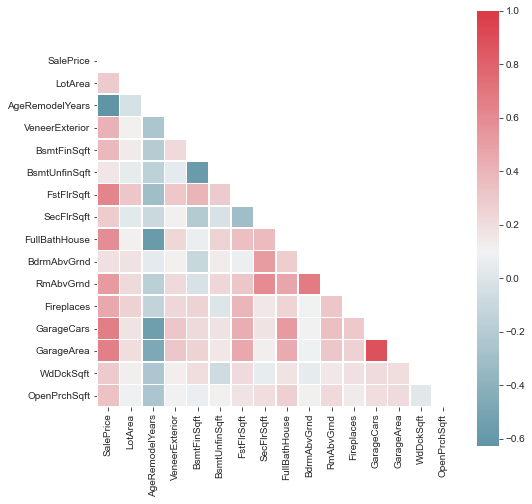

In [1150]:
#Heat map of all interval variables for 'SalePrice'
train_interval_corr = TrainingSet[['SalePrice', 'LotArea','AgeRemodelYears','VeneerExterior','BsmtFinSqft','BsmtUnfinSqft','FstFlrSqft','SecFlrSqft','FullBathHouse','BdrmAbvGrnd','RmAbvGrnd','Fireplaces','GarageCars','GarageArea','WdDckSqft','OpenPrchSqft']].corr()



mask = np.triu(np.ones_like(train_interval_corr,bool))
f, ax = plt.subplots(1,1, figsize=(8,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(train_interval_corr, mask=mask, cmap=cmap, vmax=1, center=0.1, square=True, ax=ax,
           linewidths=.5)

<AxesSubplot:>

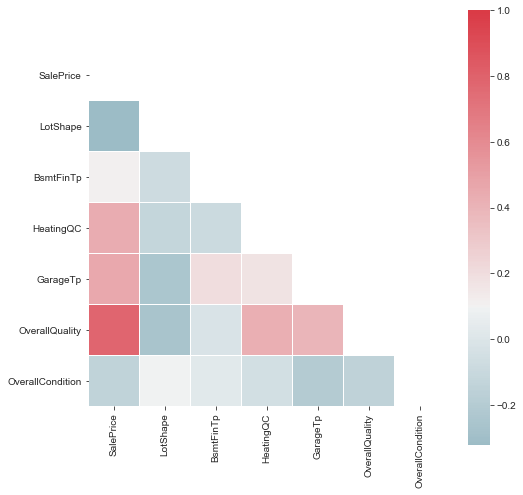

In [1151]:
#Heat map of all nominal variables for 'SalePrice'
train_interval_corr = TrainingSet[['SalePrice', 'LotShape', 'BsmtFinTp','HeatingQC','GarageTp','OverallQuality','OverallCondition']].corr()



mask = np.triu(np.ones_like(train_interval_corr,bool))
f, ax = plt.subplots(1,1, figsize=(8,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(train_interval_corr, mask=mask, cmap=cmap, vmax=1, center=0.1, square=True, ax=ax,
           linewidths=.5)

1. Of the interval input variables, likely useful ones include:
    1. FstFirSqft
    1. FullBathHouse
    1. RmAbvGrnd
    1. Fireplaces
    1. GarageCars
1. Of the binary input variables:
    1. HeatingQC
    1. GarageTp
    1. OverallQuality

**NOTE**  

OverallQuality by far is the most informative attribute for predicting SalesPrice

Although  GarageCars and GarageTp seem similar, they do not have a high corelation so we keep these attributes in the model.
GarageAreas is correlated to GarageCars though.

## Step 3.1: Preprocess the Train Dataset
Continue to finish preprocessing the Train data

In [1152]:
## column labels of all binary and nominal variables - confirm there are 17 items
oneHotCols = ['BldgTp', 'LotShape', 'BsmtFinTp', 'FullBathBsmt', 'HalfBathHouse']

dfDummified = pd.get_dummies(TrainingSet[oneHotCols])
display(dfDummified.head(), dfDummified.tail())

,BldgTp,LotShape,BsmtFinTp,FullBathBsmt,HalfBathHouse
0,1,0,1,1,0
1,1,1,1,0,0
2,1,0,1,0,1
3,1,1,1,1,1
4,1,0,1,0,1


,BldgTp,LotShape,BsmtFinTp,FullBathBsmt,HalfBathHouse
2365,1,1,1,1,0
2366,1,0,1,1,0
2367,1,0,1,1,0
2368,1,1,1,0,0
2369,1,1,1,1,0


In [1153]:
print(f'Total number of input variables to preprocess: {TrainingSet.drop(columns=["SalePrice"]).shape[1]}')

Total number of input variables to preprocess: 26


In [1154]:
oneHotEncoder = preprocessing.OneHotEncoder()

In [1155]:
print(oneHotCols)
oneHotEncoder.fit(TrainingSet[oneHotCols])

# use np.concatenate() function to "glue" all arrays into just one array, then convert to list
encodedLabels = np.concatenate(oneHotEncoder.categories_)
print('\nAfter encoding, there are {} columns encoded with labels as followws:\n'.format(encodedLabels.shape[0]))
print(list(encodedLabels))

['BldgTp', 'LotShape', 'BsmtFinTp', 'FullBathBsmt', 'HalfBathHouse']

After encoding, there are 10 columns encoded with labels as followws:

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


In [1156]:
# separate target and input dataframes
Y = TrainingSet[['SalePrice']]
X = TrainingSet.drop(columns='SalePrice')

# preprae label lists: make sure all input variables are included: 30 in total verified
binominalCols = ['BldgTp', 'LotShape', 'BsmtFinTp', 'FullBathBsmt', 'HalfBathHouse']
intervalLogCols = ['LotArea', 'VeneerExterior', 'OpenPrchSqft']
intervalCols = ['AgeRemodelYears' , 'BsmtFinSqft', 'BsmtUnfinSqft', 'FstFlrSqft', 'SecFlrSqft', 'AbvGrndLiving', 
                'FullBathHouse', 'BdrmAbvGrnd', 'RmAbvGrnd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WdDckSqft']
OrdinalCol1 = ['OverallQuality']
OrdinalCol2 = ['OverallCondition']
OrdinalCol3 = ['HeatingQC']
OrdinalCol4 = ['GarageTp']

In [1157]:

X_binominal = X[binominalCols].copy()
X_intervalLog = X[intervalLogCols].copy()
X_interval = X[intervalCols].copy()
X_ordinal1 = X[OrdinalCol1].copy()
X_ordinal2 = X[OrdinalCol2].copy()
X_ordinal3 = X[OrdinalCol3].copy()
X_ordinal4 = X[OrdinalCol4].copy()
# sanity check
X_binominal.shape, X_intervalLog.shape, X_interval.shape, X_ordinal1.shape, X_ordinal2.shape, X_ordinal3.shape, X_ordinal4.shape

((2370, 5), (2370, 3), (2370, 13), (2370, 1), (2370, 1), (2370, 1), (2370, 1))

In [1158]:
# make Pipeline 1 for X_nominal
## Pipeline 1: nominal variables only -> impute missing values -> One Hot Encoding (then clean labels)
transformerbinominal = make_pipeline(SimpleImputer(strategy = 'most_frequent'), preprocessing.OneHotEncoder())

In [1159]:
oneHotEncoder = preprocessing.OneHotEncoder()
oneHotEncoder.fit(X_binominal)
labelsPpl1= ['BldgTp Town', 'BldgTp Detached', 'LotShape NR', 'LotShape R',
                                            'BsmtFinTp UF', 'BsmtFiinTp F','FullBathBsmt not', 'FullBathBsmt yes',
                                            'HalfBathHouse not', 'HalfBathHouse yes']

In [1160]:
# test Pipeline 1
outputPpl1 = transformerbinominal.fit_transform(X_binominal).toarray()
outPpl1 = pd.DataFrame(outputPpl1, columns=labelsPpl1, index=X_binominal.index)
outPpl1.head()

,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [1161]:
# make Pipeline 2 for X_intervalLog
## Pipeline 2: interval variables that need logarithm transformation -> impute missing values -> 
##               log1p transformation -> z-standardization
transformerIntervalLog = make_pipeline(SimpleImputer(strategy = 'median'), 
                                       preprocessing.FunctionTransformer(np.log1p, validate=False),
                                       preprocessing.StandardScaler())

labelsPpl2 = X_intervalLog.add_suffix('Log1p_z').columns.tolist()

In [1162]:
# test Pipeline 2
outputPpl2 = transformerIntervalLog.fit_transform(X_intervalLog)
outPpl2 = pd.DataFrame(outputPpl2, columns=labelsPpl2, index=X_intervalLog.index)
outPpl2.head()

,LotAreaLog1p_z,VeneerExteriorLog1p_z,OpenPrchSqftLog1p_z
0,2.577555,1.086051,0.857098
1,0.596241,-0.762629,-1.073082
2,1.000227,1.071958,0.609151
3,0.516323,-0.762629,-1.073082
4,0.938936,-0.762629,0.583263


In [1163]:
# make Pipeline 3 for X_interval
## Pipeline 3: the rest of interval variables -> impute missing values -> z-standardization
transformerInterval = make_pipeline(SimpleImputer(strategy = 'median'), preprocessing.StandardScaler())

labelsPpl3 = X_interval.add_suffix('_z').columns.tolist()

In [1164]:
# test Pipeline 3
outputPpl3 = transformerInterval.fit_transform(X_interval)
outPpl3 = pd.DataFrame(outputPpl3, columns=labelsPpl3, index=X_interval.index)
outPpl3.head()

,AgeRemodelYears_z,BsmtFinSqft_z,BsmtUnfinSqft_z,FstFlrSqft_z,SecFlrSqft_z,AbvGrndLiving_z,FullBathHouse_z,BdrmAbvGrnd_z,RmAbvGrnd_z,Fireplaces_z,GarageCars_z,GarageArea_z,WdDckSqft_z
0,0.761241,0.511861,-0.282762,1.567525,-0.800760,0.470986,-1.012751,0.247145,0.532453,2.237915,0.396435,0.354417,0.981410
1,0.717312,0.093454,-0.699227,-0.640431,-0.800760,-1.234949,-1.012751,-1.099367,-0.903987,-0.935198,-1.014303,1.376856,0.400936
2,0.849099,1.206758,-0.368003,0.617523,-0.800760,-0.263015,-1.012751,0.247145,-0.185767,-0.935198,-1.014303,-0.738884,2.498934
3,0.409809,1.554206,1.188261,2.886488,-0.800760,1.490057,0.980787,0.247145,1.250673,2.237915,0.396435,0.324048,-0.760011
4,-0.886096,0.883777,-1.023144,-0.547464,0.925362,0.410380,0.980787,0.247145,-0.185767,0.651359,0.396435,0.121585,0.997995


In [1165]:
# make Pipeline 4 for OrdinalCol1
transformerOrdinal1 = make_pipeline(SimpleImputer(strategy = 'most_frequent'), preprocessing.OneHotEncoder())

In [1166]:
oneHotEncoder1 = preprocessing.OneHotEncoder()
oneHotEncoder1.fit(X_ordinal1)

OneHotEncoder()

In [1167]:
outputPpl4 = transformerOrdinal1.fit_transform(X_ordinal1).toarray()

In [1168]:
labelsPpl4= ['OQ_Poor', 'OQ_Fair', 'OQ_Below Average', 'OQ_Average', 'OQ_Above Average', 
                                              'OQ_Good', 'OQ_Very Good', 'OQ_Excellent', 'OQ_Very Excellent']

In [1169]:
# test Pipeline 4
outputPpl4 = transformerOrdinal1.fit_transform(X_ordinal1).toarray()
outPpl4 = pd.DataFrame(outputPpl4, columns = labelsPpl4, index=X_ordinal1.index)
outPpl4.head()

,OQ_Poor,OQ_Fair,OQ_Below Average,OQ_Average,OQ_Above Average,OQ_Good,OQ_Very Good,OQ_Excellent,OQ_Very Excellent
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1170]:
# make Pipeline 5 for OrdinalCol2
transformerOrdinal2 = make_pipeline(SimpleImputer(strategy = 'most_frequent'), preprocessing.OneHotEncoder())

oneHotEncoder2 = preprocessing.OneHotEncoder()
oneHotEncoder2.fit(X_ordinal2)
outputPpl5 = transformerOrdinal2.fit_transform(X_ordinal2).toarray()
labelsPpl5 = ['OC_Very Poor' ,'OC_Poor', 'OC_Fair', 'OC_Below Average', 'OC_Average', 'OC_Above Average', 
                                              'OC_Good', 'OC_Very Good', 'OC_Excellent']

In [1171]:
# test Pipeline 5
outputPpl5 = transformerOrdinal2.fit_transform(X_ordinal2).toarray()
outPpl5 = pd.DataFrame(outputPpl5, columns = labelsPpl5, index=X_ordinal2.index)
outPpl5.head()

,OC_Very Poor,OC_Poor,OC_Fair,OC_Below Average,OC_Average,OC_Above Average,OC_Good,OC_Very Good,OC_Excellent
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [1172]:
# make Pipeline 6 for OrdinalCol3
transformerOrdinal3 = make_pipeline(SimpleImputer(strategy = 'most_frequent'), preprocessing.OneHotEncoder())

oneHotEncoder3 = preprocessing.OneHotEncoder()
oneHotEncoder3.fit(X_ordinal3)
outputPpl6 = transformerOrdinal3.fit_transform(X_ordinal3).toarray()
labelsPpl6 = ['HQC_Fair', 'HQC_Average', 'HQC_Good', 'HQC_Excellent']

In [1173]:
# test Pipeline 6
outputPpl6 = transformerOrdinal3.fit_transform(X_ordinal3).toarray()
outPpl6 = pd.DataFrame(outputPpl6, columns = labelsPpl6, index=X_ordinal3.index)
outPpl6.head()

,HQC_Fair,HQC_Average,HQC_Good,HQC_Excellent
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0


In [1174]:
# make Pipeline 7 for OrdinalCol4
transformerOrdinal4 = make_pipeline(SimpleImputer(strategy = 'most_frequent'), preprocessing.OneHotEncoder())

oneHotEncoder4 = preprocessing.OneHotEncoder()
oneHotEncoder4.fit(X_ordinal4)
outputPpl7 = transformerOrdinal4.fit_transform(X_ordinal4).toarray()
labelsPpl7 = ['Garage_No garage', 'Garage_Detached', 'Garage_Builtin', 'Garage_Attached']

In [1175]:
# test Pipeline 7
outputPpl7 = transformerOrdinal4.fit_transform(X_ordinal4).toarray()
outPpl7 = pd.DataFrame(outputPpl7, columns = labelsPpl7, index=X_ordinal4.index)
outPpl7.head()

,Garage_No garage,Garage_Detached,Garage_Builtin,Garage_Attached
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


In [1176]:
# combine all 7 Pipelines into a ColumnTransformer
preprocessor = make_column_transformer((transformerbinominal, binominalCols), 
                                       (transformerIntervalLog, intervalLogCols),
                                       (transformerInterval, intervalCols),
                                      (transformerOrdinal1, OrdinalCol1),
                                      (transformerOrdinal2, OrdinalCol2),
                                      (transformerOrdinal3, OrdinalCol3),
                                      (transformerOrdinal4, OrdinalCol4))

# prepare all labels
## list comprehension again
labelsPreprocessor = [label for labels in [labelsPpl1, labelsPpl2, labelsPpl3, labelsPpl4, labelsPpl5,
                                          labelsPpl6, labelsPpl7] for label in labels]
print(labelsPreprocessor)

['BldgTp Town', 'BldgTp Detached', 'LotShape NR', 'LotShape R', 'BsmtFinTp UF', 'BsmtFiinTp F', 'FullBathBsmt not', 'FullBathBsmt yes', 'HalfBathHouse not', 'HalfBathHouse yes', 'LotAreaLog1p_z', 'VeneerExteriorLog1p_z', 'OpenPrchSqftLog1p_z', 'AgeRemodelYears_z', 'BsmtFinSqft_z', 'BsmtUnfinSqft_z', 'FstFlrSqft_z', 'SecFlrSqft_z', 'AbvGrndLiving_z', 'FullBathHouse_z', 'BdrmAbvGrnd_z', 'RmAbvGrnd_z', 'Fireplaces_z', 'GarageCars_z', 'GarageArea_z', 'WdDckSqft_z', 'OQ_Poor', 'OQ_Fair', 'OQ_Below Average', 'OQ_Average', 'OQ_Above Average', 'OQ_Good', 'OQ_Very Good', 'OQ_Excellent', 'OQ_Very Excellent', 'OC_Very Poor', 'OC_Poor', 'OC_Fair', 'OC_Below Average', 'OC_Average', 'OC_Above Average', 'OC_Good', 'OC_Very Good', 'OC_Excellent', 'HQC_Fair', 'HQC_Average', 'HQC_Good', 'HQC_Excellent', 'Garage_No garage', 'Garage_Detached', 'Garage_Builtin', 'Garage_Attached']


In [1177]:
# run ColumnTransformer and Pipelines, make dataframe
outputPreprocessor = preprocessor.fit_transform(X)
dfPreprocessed = pd.DataFrame(outputPreprocessor, columns=labelsPreprocessor, index=X.index)
display(dfPreprocessed.shape, dfPreprocessed.head(), dfPreprocessed.tail(), dfPreprocessed[['VeneerExteriorLog1p_z']].head())

(2370, 52)

,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes,...,OC_Very Good,OC_Excellent,HQC_Fair,HQC_Average,HQC_Good,HQC_Excellent,Garage_No garage,Garage_Detached,Garage_Builtin,Garage_Attached
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes,...,OC_Very Good,OC_Excellent,HQC_Fair,HQC_Average,HQC_Good,HQC_Excellent,Garage_No garage,Garage_Detached,Garage_Builtin,Garage_Attached
2365,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2366,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2367,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2368,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2369,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


,VeneerExteriorLog1p_z
0,1.086051
1,-0.762629
2,1.071958
3,-0.762629
4,-0.762629


In [1178]:
# adjust the "weight" of all flag variables: from 1 to 0.707
dfWeightedFlags = dfPreprocessed[labelsPpl1].replace(to_replace={1: 0.707})
dfWeightedFlags.head()

,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes
0,0.0,0.707,0.707,0.000,0.0,0.707,0.000,0.707,0.707,0.000
1,0.0,0.707,0.000,0.707,0.0,0.707,0.707,0.000,0.707,0.000
2,0.0,0.707,0.707,0.000,0.0,0.707,0.707,0.000,0.000,0.707
3,0.0,0.707,0.000,0.707,0.0,0.707,0.000,0.707,0.000,0.707
4,0.0,0.707,0.707,0.000,0.0,0.707,0.707,0.000,0.000,0.707


In [1179]:
# make new dataframe for kNN only if needed
dfPreprocessedKNN = dfPreprocessed.copy()
dfPreprocessedKNN[labelsPpl1] = dfWeightedFlags
display(dfPreprocessedKNN.shape, dfPreprocessedKNN.head(), dfPreprocessedKNN.tail())

(2370, 52)

,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes,...,OC_Very Good,OC_Excellent,HQC_Fair,HQC_Average,HQC_Good,HQC_Excellent,Garage_No garage,Garage_Detached,Garage_Builtin,Garage_Attached
0,0.0,0.707,0.707,0.000,0.0,0.707,0.000,0.707,0.707,0.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.707,0.000,0.707,0.0,0.707,0.707,0.000,0.707,0.000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.707,0.707,0.000,0.0,0.707,0.707,0.000,0.000,0.707,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.707,0.000,0.707,0.0,0.707,0.000,0.707,0.000,0.707,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.707,0.707,0.000,0.0,0.707,0.707,0.000,0.000,0.707,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes,...,OC_Very Good,OC_Excellent,HQC_Fair,HQC_Average,HQC_Good,HQC_Excellent,Garage_No garage,Garage_Detached,Garage_Builtin,Garage_Attached
2365,0.0,0.707,0.000,0.707,0.0,0.707,0.000,0.707,0.707,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2366,0.0,0.707,0.707,0.000,0.0,0.707,0.000,0.707,0.707,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2367,0.0,0.707,0.707,0.000,0.0,0.707,0.000,0.707,0.707,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2368,0.0,0.707,0.000,0.707,0.0,0.707,0.707,0.000,0.707,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2369,0.0,0.707,0.000,0.707,0.0,0.707,0.000,0.707,0.707,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


***
# Modeling & Evaluation

## Step 3: Build Models

In [1180]:
# Y_final for models
yScaler = preprocessing.StandardScaler()
Y_final = pd.DataFrame(yScaler.fit_transform(Y), columns=['SalePrice'])
Y_final.head(3)

,SalePrice
0,0.644154
1,-1.072790
2,-0.027015


In [1181]:
print(f'Original values of "SalePrice" in the first 5 rows: {Y["SalePrice"].head().tolist()}')
print(f'After z-standardization, values are: {np.round(Y_final["SalePrice"].head(), 2).tolist()}')
# .flatten() method is used because the output is a nested ndarray
print('Finally, after reversing standardization, values should be almost the same as original: {}. Success!'.format(
    yScaler.inverse_transform(Y_final)[:5].astype(int).flatten().tolist()
))

Original values of "SalePrice" in the first 5 rows: [215000, 105000, 172000, 244000, 189900]
After z-standardization, values are: [0.64, -1.07, -0.03, 1.1, 0.25]
Finally, after reversing standardization, values should be almost the same as original: [215000, 105000, 172000, 244000, 189900]. Success!


In [1182]:
# X_finalKNN for kNN only if needed
X_finalKNN = dfPreprocessedKNN
X_finalKNN.shape, X_finalKNN.isnull().sum().sum()

((2370, 52), 0)

In [1183]:
# X_final for linear regression only
X_final = dfPreprocessed
X_final.shape, X_final.isnull().sum().sum()

((2370, 52), 0)

Linear Regression Model

In [1184]:

from sklearn.feature_selection import RFE

In [1185]:
# first, define a linear regression instance
regRFE = lm.LinearRegression()

In [1186]:
# second, define an RFE which retains 27 most significant inputs
rfe_15 = RFE(regRFE, n_features_to_select=27)

In [1187]:
# third, fit this rfe
rfe_15.fit(X=X_final, y=Y_final['SalePrice'])

RFE(estimator=LinearRegression(), n_features_to_select=27)

In [1188]:
# get the names of the retained columns
display(X_final.columns[rfe_15.get_support()].shape[0],
        X_final.columns[rfe_15.get_support()])

27

Index(['BldgTp Town', 'BldgTp Detached', 'LotShape NR', 'LotShape R',
       'BsmtFinTp UF', 'BsmtFiinTp F', 'FullBathBsmt not', 'FullBathBsmt yes',
       'HalfBathHouse not', 'HalfBathHouse yes', 'OQ_Poor', 'OQ_Fair',
       'OQ_Below Average', 'OQ_Average', 'OQ_Above Average', 'OQ_Good',
       'OQ_Very Good', 'OQ_Excellent', 'OQ_Very Excellent', 'HQC_Fair',
       'HQC_Average', 'HQC_Good', 'HQC_Excellent', 'Garage_No garage',
       'Garage_Detached', 'Garage_Builtin', 'Garage_Attached'],
      dtype='object')

In [1189]:
# fit 12 times each with a different n_features_to_select value -- result stored in 18 columns
df_retained_bool = pd.DataFrame()
for i in range(1, 12):
    rfe_temp = RFE(regRFE, n_features_to_select = i)
    rfe_temp.fit(X = X_final, y = Y_final['SalePrice'])
    df_retained_bool['retained_' + str(i)] = rfe_temp.get_support()

display(df_retained_bool.shape, df_retained_bool.sum())

(52, 11)

retained_1      1
retained_2      2
retained_3      3
retained_4      4
retained_5      5
retained_6      6
retained_7      7
retained_8      8
retained_9      9
retained_10    10
retained_11    11
dtype: int64

In [1190]:
# using the 11 iterations of selected features, calculate their x-valid scores for each
regression = lm.LinearRegression()
df_xvalid_reg = pd.DataFrame()
for label, content in df_retained_bool.iteritems():
    selected_labels_list = X_final.columns[content.to_numpy()]
    df_xvalid_reg[label] = cross_val_score(regression, X = X_final[selected_labels_list], y = Y_final['SalePrice'], cv = 10, 
                                           scoring = 'neg_mean_squared_error')

df_xvalid_reg.shape

(10, 11)

In [1191]:
xvalid_mean_reg = df_xvalid_reg.mean()
xvalid_mean_reg

retained_1    -0.958653
retained_2    -0.959182
retained_3    -0.862580
retained_4    -0.862310
retained_5    -0.862284
retained_6    -0.786653
retained_7    -0.522629
retained_8    -0.388072
retained_9    -0.349456
retained_10   -0.340424
retained_11   -0.339963
dtype: float64

kNN model

In [1192]:
df_xvalid_knnlwa = pd.DataFrame()
for i in range(2, 16, 2):
    # define a kNN instance
    knnlwa_temp = knn.KNeighborsRegressor(n_neighbors=i, weights='distance')
    df_xvalid_knnlwa['k_' + str(i)] = cross_val_score(knnlwa_temp, X = X_finalKNN, y = Y_final['SalePrice'], cv = 10, 
                                                      scoring = 'neg_mean_squared_error')

df_xvalid_knnlwa.shape

(10, 7)

In [1193]:
xvalid_mean_knnlwa = df_xvalid_knnlwa.mean()
xvalid_mean_knnlwa

k_2    -0.184255
k_4    -0.156677
k_6    -0.147163
k_8    -0.143138
k_10   -0.144639
k_12   -0.145933
k_14   -0.148229
dtype: float64

In [1194]:
##Evaluation

In [1195]:
## Regression Model

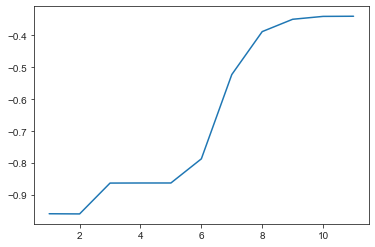

In [1196]:
newfig = plt.figure(figsize=(6,4))
# below codes use an anonymous function
s_numbering = pd.Series(xvalid_mean_reg.index).apply(lambda x:x[9:]).astype(int)
xvalid_mean_reg_copy = xvalid_mean_reg.copy()
xvalid_mean_reg_copy.index = s_numbering
figXvalReg = xvalid_mean_reg_copy.plot.line()

In [1197]:
## 12 selected features has the highest score

In [1198]:
figXvalReg.set_xlabel('regression model: n_selected_features')
figXvalReg.set_ylabel('neg mean squared error')
figXvalReg.set_xticks(s_numbering)

In [1199]:
#kNN model eval

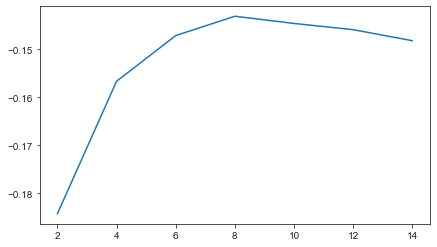

In [1200]:
newfig = plt.figure(figsize=(7,4))
s_numbering = pd.Series(xvalid_mean_knnlwa.index).apply(lambda x:x[2:]).astype(np.int)
xvalid_mean_knnlwa_copy = xvalid_mean_knnlwa.copy()
xvalid_mean_knnlwa_copy.index = s_numbering
figXvalKnn = xvalid_mean_knnlwa_copy.plot.line()

k = 8 has the highest x-valid score

In [1201]:
figXvalKnn.set_xlabel('kNN model: k')
figXvalKnn.set_ylabel('neg mean squared error')
figXvalKnn.set_xticks(s_numbering)

In [1202]:
xvalid_mean_knnlwa.sort_values(ascending=False)

k_8    -0.143138
k_10   -0.144639
k_12   -0.145933
k_6    -0.147163
k_14   -0.148229
k_4    -0.156677
k_2    -0.184255
dtype: float64

In [1203]:
## Selecting model

In [1204]:
# Best regression model's features boolean series: best model has n_selected_features = 11
best_features_bool = df_retained_bool[df_retained_bool.columns[df_retained_bool.columns == 'retained_11']]
best_features_bool = np.squeeze(best_features_bool)
best_features_bool.sum()

11

In [1205]:
# double-check the x-valid performance of this model, making sure indexed features boolean series is correct
xvalid_best_reg = cross_val_score(regression, X=X_final[X_final.columns[best_features_bool]], y=Y_final['SalePrice'], cv=10, 
                                  scoring='neg_mean_squared_error')

In [1206]:
xvalid_best_reg.mean()

-0.3399630425789012

In [1207]:
# verified, same as when n = 11

In [1208]:
# Best kNN(LWA) model's specification : k = 8
knnlwa_24 = knn.KNeighborsRegressor(n_neighbors=8, weights='distance')
xvalid_best_knnlwa = cross_val_score(knnlwa_24, X=X_finalKNN, y=Y_final['SalePrice'], cv=10, scoring='neg_mean_squared_error')

In [1209]:
xvalid_best_knnlwa.mean()  #verified ~ -0.15

-0.1431384226972411

In [1210]:
#Comparison betw models:

k values are similar for both.  We will also include the variables from the heatmap

In [1211]:
Bestmodelvars = X_finalKNN.columns.values[best_features_bool]
Bestmodelvars

array(['LotShape NR', 'LotShape R', 'FullBathBsmt not',
       'FullBathBsmt yes', 'OQ_Below Average', 'OQ_Average',
       'OQ_Above Average', 'OQ_Good', 'OQ_Very Good', 'OQ_Excellent',
       'OQ_Very Excellent'], dtype=object)

In [1212]:
HeatmapIntervalvars = ['FstFlrSqft_z', 'FullBathHouse_z', 'RmAbvGrnd_z', 'Fireplaces_z', 'GarageCars_z']

In [1213]:
BestModelsVars = np.concatenate([Bestmodelvars] + [HeatmapIntervalvars])

In [1214]:
BestModelsVars

array(['LotShape NR', 'LotShape R', 'FullBathBsmt not',
       'FullBathBsmt yes', 'OQ_Below Average', 'OQ_Average',
       'OQ_Above Average', 'OQ_Good', 'OQ_Very Good', 'OQ_Excellent',
       'OQ_Very Excellent', 'FstFlrSqft_z', 'FullBathHouse_z',
       'RmAbvGrnd_z', 'Fireplaces_z', 'GarageCars_z'], dtype=object)

## Step 3.2: Preprocess the Score Dataset
Use what have been developed for the Train data above to preprocess the Score data

In [1215]:
dfScore = pd.read_csv('Score_Data-No_Sale_Price.csv')

In [1216]:
nrow_score, ncol_score = dfScore.shape
nrow_score, ncol_score

(100, 27)

In [1217]:
dfScore.head(3)

,PID,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,...,HalfBathHouse,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft
0,528445060,8987,1,1,8,5,2005,2006,226.0,0,...,0,2,2.0,6.0,1,3,3,880,144,0
1,528456160,9215,1,1,7,5,2009,2010,0.0,0,...,0,2,2.0,4.0,0,3,2,676,0,136
2,528458070,8640,1,1,7,5,2009,2009,0.0,1,...,1,2,3.0,7.0,0,3,2,614,169,45


In [1218]:
dfScore["YearBuilt"] = dfScore["YearBuilt"].apply(age_calc)

In [1219]:
dfScore.head()

,PID,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition,YearBuilt,YearRemodel,VeneerExterior,BsmtFinTp,...,HalfBathHouse,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft
0,528445060,8987,1,1,8,5,16,2006,226.0,0,...,0,2,2.0,6.0,1,3,3,880,144,0
1,528456160,9215,1,1,7,5,12,2010,0.0,0,...,0,2,2.0,4.0,0,3,2,676,0,136
2,528458070,8640,1,1,7,5,12,2009,0.0,1,...,1,2,3.0,7.0,0,3,2,614,169,45
3,906380190,6762,1,1,7,5,15,2006,24.0,1,...,0,2,2.0,6.0,0,3,2,632,105,61
4,906385010,10402,0,1,7,5,12,2009,0.0,0,...,0,2,3.0,6.0,0,3,3,740,0,36


In [1220]:
dfScore.rename(columns={'YearBuilt': 'Age'}, inplace=True)

In [1221]:
dfScore["YearRemodel"] = dfScore["YearRemodel"].apply(age_calc)
dfScore.rename(columns={'YearRemodel': 'RemodelAge'}, inplace=True)

In [1222]:
dfScore.head()

,PID,LotArea,LotShape,BldgTp,OverallQuality,OverallCondition,Age,RemodelAge,VeneerExterior,BsmtFinTp,...,HalfBathHouse,FullBathHouse,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft
0,528445060,8987,1,1,8,5,16,15,226.0,0,...,0,2,2.0,6.0,1,3,3,880,144,0
1,528456160,9215,1,1,7,5,12,11,0.0,0,...,0,2,2.0,4.0,0,3,2,676,0,136
2,528458070,8640,1,1,7,5,12,12,0.0,1,...,1,2,3.0,7.0,0,3,2,614,169,45
3,906380190,6762,1,1,7,5,15,15,24.0,1,...,0,2,2.0,6.0,0,3,2,632,105,61
4,906385010,10402,0,1,7,5,12,12,0.0,0,...,0,2,3.0,6.0,0,3,3,740,0,36


In [1223]:
dfScore["AgeRemodelYears"] = dfScore["Age"] + dfScore["RemodelAge"]

In [1224]:
dfScore.drop('Age',  inplace=True, axis=1)
dfScore.drop('RemodelAge',  inplace=True, axis=1)

In [1225]:
dfScorecols = dfScore.columns.tolist()
dfScorecols

['PID',
 'LotArea',
 'LotShape',
 'BldgTp',
 'OverallQuality',
 'OverallCondition',
 'VeneerExterior',
 'BsmtFinTp',
 'BsmtFinSqft',
 'BsmtUnfinSqft',
 'HeatingQC',
 'FstFlrSqft',
 'SecFlrSqft',
 'AbvGrndLiving',
 'FullBathBsmt',
 'HalfBathHouse',
 'FullBathHouse',
 'BdrmAbvGrnd',
 'RmAbvGrnd',
 'Fireplaces',
 'GarageTp',
 'GarageCars',
 'GarageArea',
 'WdDckSqft',
 'OpenPrchSqft',
 'AgeRemodelYears']

In [1226]:
dfScore = dfScore[dfScorecols]

In [1227]:
dfScore.index = np.arange(TrainingSet.shape[0] + 100, TrainingSet.shape[0] + 100 + nrow_score, 1)

# sanity check
print('Ending index of train data: {}\nBeginning index of score data: {}'.format(
    TrainingSet.index.values[-1], dfScore.index.values[0]))

Ending index of train data: 2369
Beginning index of score data: 2470


In [1228]:
dfScore = dfScore[TrainingSet.drop('SalePrice', axis=1).columns]

In [1229]:
print('Is there any difference in the input column labels between the two dataframes?', 
      (dfScore.columns != TrainingSet.drop('SalePrice', axis=1).columns).any())

Is there any difference in the input column labels between the two dataframes? False


In [1230]:
dfScore.head(3)

,PID,LotArea,LotShape,BldgTp,AgeRemodelYears,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,...,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,OverallQuality,OverallCondition
2470,528445060,8987,1,1,31,226.0,0,0,1595,3,...,2.0,6.0,1,3,3,880,144,0,8,5
2471,528456160,9215,1,1,23,0.0,0,0,1218,3,...,2.0,4.0,0,3,2,676,0,136,7,5
2472,528458070,8640,1,1,24,0.0,1,24,732,3,...,3.0,7.0,0,3,2,614,169,45,7,5


In [1231]:
dfScore.describe()

,PID,LotArea,LotShape,BldgTp,AgeRemodelYears,VeneerExterior,BsmtFinTp,BsmtFinSqft,BsmtUnfinSqft,HeatingQC,...,BdrmAbvGrnd,RmAbvGrnd,Fireplaces,GarageTp,GarageCars,GarageArea,WdDckSqft,OpenPrchSqft,OverallQuality,OverallCondition
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,97.000000,100.000000,100.000000,100.000000,100.000000,...,95.000000,96.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,6.576229e+08,9322.570000,0.460000,0.910000,57.900000,137.659794,0.670000,402.850000,647.390000,2.520000,...,2.789474,6.500000,0.540000,2.61000,2.010000,532.280000,108.53000,48.370000,6.520000,5.350000
std,1.808138e+08,2775.829625,0.500908,0.287623,31.717025,194.065490,0.472582,378.931309,418.081957,0.822413,...,0.523790,1.222594,0.610017,0.75069,0.437971,140.276788,123.17471,45.848599,1.029661,0.715979
min,5.271631e+08,1680.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,4.000000,0.000000,1.00000,1.000000,186.000000,0.00000,0.000000,4.000000,4.000000
25%,5.274515e+08,8126.500000,0.000000,1.000000,34.750000,0.000000,0.000000,0.000000,300.000000,2.000000,...,2.000000,6.000000,0.000000,3.00000,2.000000,440.000000,0.00000,0.000000,6.000000,5.000000
50%,5.284571e+08,9008.500000,0.000000,1.000000,44.000000,72.000000,1.000000,417.500000,574.500000,3.000000,...,3.000000,6.000000,0.000000,3.00000,2.000000,528.500000,100.00000,43.500000,7.000000,5.000000
75%,9.071821e+08,10461.000000,1.000000,1.000000,88.500000,202.000000,1.000000,716.250000,867.250000,3.000000,...,3.000000,7.000000,1.000000,3.00000,2.000000,614.250000,192.00000,73.250000,7.000000,5.250000
max,9.144764e+08,16900.000000,1.000000,1.000000,171.000000,1110.000000,1.000000,1350.000000,1704.000000,3.000000,...,4.000000,10.000000,2.000000,3.00000,3.000000,908.000000,576.00000,224.000000,9.000000,8.000000


In [1232]:
print(f'These columns have at least 1 missing value: {dfScore.columns[dfScore.isnull().sum().astype(bool)].tolist()}')

These columns have at least 1 missing value: ['VeneerExterior', 'FstFlrSqft', 'SecFlrSqft', 'BdrmAbvGrnd', 'RmAbvGrnd']


In [1233]:
display(dfScore['BldgTp'].value_counts(), dfScore['HalfBathHouse'].value_counts(), dfScore['OverallQuality'].value_counts())

1    91
0     9
Name: BldgTp, dtype: int64

1    53
0    47
Name: HalfBathHouse, dtype: int64

7    48
6    26
5    10
8     9
4     5
9     2
Name: OverallQuality, dtype: int64

In [1234]:
#Pre process Variables

In [1235]:
colBoolSelector = dfScore.isnull().sum().astype(bool)
print('The columns with missing value is:', dfScore.columns.values[colBoolSelector])

The columns with missing value is: ['VeneerExterior' 'FstFlrSqft' 'SecFlrSqft' 'BdrmAbvGrnd' 'RmAbvGrnd']


In [1236]:
# prepare all labels
##(copy those codes from previous module; things e.g. labelsPpl1 are defined because you imported the entire module 9)
labelsPreprocessor = [label for labels in [labelsPpl1, labelsPpl2, labelsPpl3, labelsPpl4, labelsPpl5,
                                          labelsPpl6, labelsPpl7] for label in labels]
print(labelsPreprocessor)

['BldgTp Town', 'BldgTp Detached', 'LotShape NR', 'LotShape R', 'BsmtFinTp UF', 'BsmtFiinTp F', 'FullBathBsmt not', 'FullBathBsmt yes', 'HalfBathHouse not', 'HalfBathHouse yes', 'LotAreaLog1p_z', 'VeneerExteriorLog1p_z', 'OpenPrchSqftLog1p_z', 'AgeRemodelYears_z', 'BsmtFinSqft_z', 'BsmtUnfinSqft_z', 'FstFlrSqft_z', 'SecFlrSqft_z', 'AbvGrndLiving_z', 'FullBathHouse_z', 'BdrmAbvGrnd_z', 'RmAbvGrnd_z', 'Fireplaces_z', 'GarageCars_z', 'GarageArea_z', 'WdDckSqft_z', 'OQ_Poor', 'OQ_Fair', 'OQ_Below Average', 'OQ_Average', 'OQ_Above Average', 'OQ_Good', 'OQ_Very Good', 'OQ_Excellent', 'OQ_Very Excellent', 'OC_Very Poor', 'OC_Poor', 'OC_Fair', 'OC_Below Average', 'OC_Average', 'OC_Above Average', 'OC_Good', 'OC_Very Good', 'OC_Excellent', 'HQC_Fair', 'HQC_Average', 'HQC_Good', 'HQC_Excellent', 'Garage_No garage', 'Garage_Detached', 'Garage_Builtin', 'Garage_Attached']


In [1237]:
outputPreprocessor_score = preprocessor.transform(dfScore)

In [1238]:
dfPreprocessed_score = pd.DataFrame(outputPreprocessor_score, columns=labelsPreprocessor, index=dfScore.index)
display(dfPreprocessed_score.shape, dfPreprocessed_score.head(3), dfPreprocessed_score.tail(3))

(100, 52)

,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes,...,OC_Very Good,OC_Excellent,HQC_Fair,HQC_Average,HQC_Good,HQC_Excellent,Garage_No garage,Garage_Detached,Garage_Builtin,Garage_Attached
2470,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2471,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2472,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


,BldgTp Town,BldgTp Detached,LotShape NR,LotShape R,BsmtFinTp UF,BsmtFiinTp F,FullBathBsmt not,FullBathBsmt yes,HalfBathHouse not,HalfBathHouse yes,...,OC_Very Good,OC_Excellent,HQC_Fair,HQC_Average,HQC_Good,HQC_Excellent,Garage_No garage,Garage_Detached,Garage_Builtin,Garage_Attached
2567,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2568,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2569,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [1239]:
dfScore.shape

(100, 26)

In [1240]:
# check missing values

dfPreprocessed_score.isna().sum().sum()

0

In [1241]:
dfWeightedFlags_score = dfPreprocessed_score[labelsPpl1].replace(to_replace={1: 0.707})
dfPreprocessedKNN_score = dfPreprocessed_score.copy()
dfPreprocessedKNN_score[labelsPpl1] = dfWeightedFlags_score

In [1242]:
X_scoreReg_final = dfPreprocessed_score
X_scoreKNN_final = dfPreprocessedKNN_score

In [1243]:
#Sanity check

X_scoreReg_final.shape, X_scoreReg_final.shape

((100, 52), (100, 52))

In [1244]:
X_scoreReg_final.isnull().sum().sum(), X_scoreKNN_final.isnull().sum().sum()

(0, 0)

In [1245]:
(X_scoreReg_final.columns != X_scoreKNN_final.columns).any(), (X_scoreReg_final.columns != X_final.columns).any()

(False, False)

## Score Prepared data

In [1246]:
reg = lm.LinearRegression()

In [1247]:
reg.fit(X=X_final[X_final.columns[best_features_bool]], y=Y_final['SalePrice'])

LinearRegression()

In [1248]:
scored_SalePrice = reg.predict(X = X_scoreReg_final[X_scoreReg_final.columns[best_features_bool]])

In [1249]:
#sanity check
display(isinstance(scored_SalePrice, np.ndarray), scored_SalePrice.shape, scored_SalePrice.dtype)
print('Mean and Std of predicted SalePrice are: {:.3f} ({:.3f})'.format(np.mean(scored_SalePrice), np.std(scored_SalePrice)))

True

(100,)

dtype('float64')

Mean and Std of predicted SalePrice are: 0.287 (0.689)


## Step 6: Predict Target of Score Data Set

In [1250]:
#Inverse transform SalePrice

In [1251]:
dfSalePrice_inversed = pd.DataFrame(yScaler.inverse_transform(scored_SalePrice), columns=['PSP'], index=X_scoreReg_final.index)


**Sanity Check**<br>
Is the predicted values missing? Make a simple plot of the predicted values for SalePrice

Text(0, 0.5, 'Scored SalePrice')

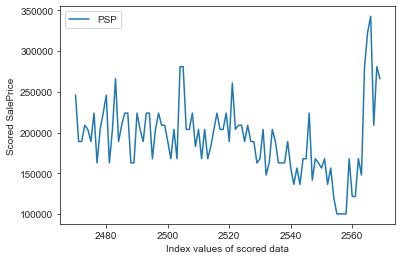

In [1252]:
line1 = dfSalePrice_inversed.plot()
line1.set_xlabel('Index values of scored data')
line1.set_ylabel('Scored SalePrice')

## Step 7: Export (save) Scored Data in Required Format

<div class="alert alert-block alert-info"><font color="red"><b>Very Important!</b></font> <br>Is the predicted "SalePrice" in the original dollar scale? The predicted values must indicate the dollar-value of the properties. <br>Make sure to reverse any transformation of the "SalePrice" if any of the following was applied to the "SalePrice" column in the above date preparation steps:
<ul>
    <li>z-standardization</li>
    <li>log-transformation</li>
</ul></div>

In [1253]:
#append PID column

PID_col = dfScore['PID']
SalePriceFinal = dfSalePrice_inversed.copy()
SalePriceFinal.insert(0,'PID',PID_col)

In [1254]:
#Export
SalePriceFinal.to_csv("Predicted_Sales_Data.csv", index=True)

# Conclusion
***
Use this section to smmarize the project by drawing conclusions. May summarize any achievement in building models, any success in further tuning and improving algorithms' performance, and any caveats that emerged in the project process and about the predicted values, etc. May also document any other important lessons learned during the project process

The prelimenary EDA consisted of standard analysis consisting of finding each dataset's shape, data types, converting variables to more meaningful formats ('YearRemodel' to 'RemodelAge'), summary statistics, distribution, and merging/appending into one dataset named 'TrainingData'. Then we looked for skewness of distributions and any outliers using matplotlib's pyplot package. Next we used a heat map to find informative attributes. After that we created dummies for the nominal variables as a part of Preprocessing the Training Dataset. Then we used the oneHotEncoder object with pipeline to further refine the training data. Finally, we built our model using Linear Regression. We chose this model because it is used for predicting variables on the interval scale, as opposed to Knn or logistic regression, which are optimized for classification problems. 

**Note**: The predicted set did not have a PID column, so we appended the PID column from the original set without the sales data, then exported it. 